In [1]:
import torch
import torch.nn as nn
import os
import mlp.data_providers as data_providers
import numpy as np
from storage_utils import load_statistics
from collections import OrderedDict
from model_architectures import ConvolutionalNetwork
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
train_data = data_providers.EMNISTDataProvider('train', batch_size=100000)
val_data = data_providers.EMNISTDataProvider('valid', batch_size=15800)
test_data = data_providers.EMNISTDataProvider('test', batch_size=1)

KeysView(<numpy.lib.npyio.NpzFile object at 0x106c0fd30>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x1191404a8>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x1191404a8>)


In [3]:
model_names = ['3', '5', '7']
downsamples = ['max_pooling', 'avg_pooling', 'strided_convolution', 'dilated_convolution']
runs = ['run1', 'run2', 'run3']
models = OrderedDict()
stats = OrderedDict()
stats_means = OrderedDict()
stats_stds = OrderedDict()

batch_size = 128
image_num_channels = 1
image_height = 28
image_width = 28
num_layers = 4
num_epochs = 50
weight_decay_coefficient = 0
seed = 7112018
use_gpu = True

In [4]:
def rename_dict_key(old_dict):
    new_dict = OrderedDict()
    for key in old_dict.keys():
        new_dict[key[6:]] = old_dict[key]
    return new_dict

In [5]:
# load summary stats
for run in runs:
    for downsample in downsamples:
        for model_name in model_names:
            experiment_log_dir = './outputs/'+ run + '/kernel/' + downsample + '/' + model_name + '/result_outputs/'
            summary = load_statistics(experiment_log_dir, 'summary.csv')
            stats[run + downsample + model_name] = summary

for downsample in downsamples:
    for model_name in model_names:
        train_accs = []
        valid_accs = []
        means_dict = {}
        stds_dict ={}
        for run in runs:
            summary = stats[run + downsample + model_name]
            train_accs.append(summary['train_acc'])
            valid_accs.append(summary['val_acc'])
        train_accs = np.array(train_accs, dtype='float')
        valid_accs = np.array(valid_accs, dtype='float')
        train_accs = train_accs * 100
        valid_accs = valid_accs * 100
        means_dict['train_acc'] = np.mean(train_accs, axis=0)
        means_dict['val_acc'] = np.mean(valid_accs, axis=0)
        stds_dict['train_acc'] = np.std(train_accs, axis=0)
        stds_dict['val_acc'] = np.std(valid_accs, axis=0)
        stats_means[downsample+model_name] = means_dict
        stats_stds[downsample+model_name] = stds_dict

In [6]:
test_stats=OrderedDict()

# load test stats
for run in runs:
    for downsample in downsamples:
        for model_name in model_names:
            experiment_log_dir = './outputs/'+ run + '/kernel/' + downsample + '/' + model_name + '/result_outputs/'
            summary = load_statistics(experiment_log_dir, 'test_summary.csv')
            test_stats[run+downsample+model_name] = summary['test_acc'][0]

for downsample in downsamples:
    for model_name in model_names:
        accs = []
        for run in runs:
            accs.append(test_stats[run+downsample+model_name])
        accs = np.array(accs, dtype='float')
        accs = accs * 100
        print(downsample + '_' + model_name + ' test_acc: {0:.2f} ({1:.4f})'.format(np.mean(accs), np.std(accs)))

max_pooling_3 test_acc: 87.87 (0.3166)
max_pooling_5 test_acc: 88.05 (0.0395)
max_pooling_7 test_acc: 87.71 (0.2372)
avg_pooling_3 test_acc: 87.87 (0.1573)
avg_pooling_5 test_acc: 88.37 (0.3844)
avg_pooling_7 test_acc: 88.51 (0.1983)
strided_convolution_3 test_acc: 87.45 (0.0463)
strided_convolution_5 test_acc: 87.65 (0.1295)
strided_convolution_7 test_acc: 87.47 (0.1551)
dilated_convolution_3 test_acc: 88.69 (0.1270)
dilated_convolution_5 test_acc: 88.41 (0.1786)
dilated_convolution_7 test_acc: 87.88 (0.1701)


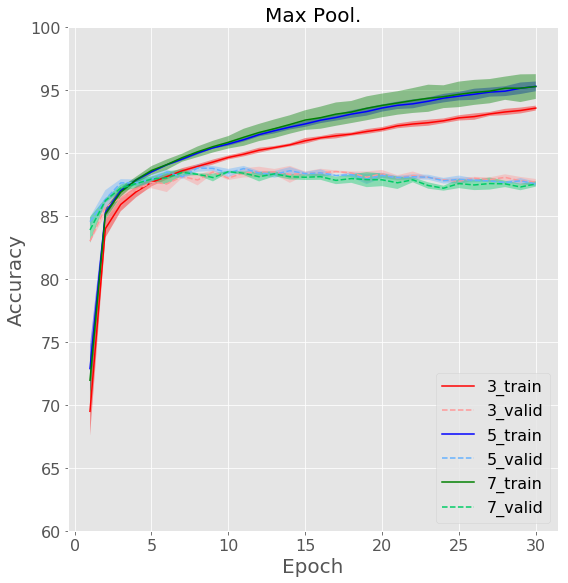

In [11]:
# training accuracy plot
plt.figure(figsize=(8,8))
colors = ['r', 'b', 'g']
colors2 = ['#FF9999', '#66B2FF', '#00CC66']
downsample = 'max_pooling' 
for model_name, c, c2 in zip(model_names,  colors, colors2):
    statistics = stats_means[downsample + model_name]
    train_acc = statistics['train_acc']
    valid_acc = statistics['val_acc']
    train_error = stats_stds[downsample + model_name]['train_acc']
    valid_error = stats_stds[downsample + model_name]['val_acc']
    plt.plot(np.arange(1, len(train_acc)+1), np.array(train_acc, dtype='float'), label=model_name+'_train', c=c)
    plt.fill_between(np.arange(1, len(train_acc)+1), train_acc - train_error, train_acc + train_error, alpha=0.4, facecolor=c)
    plt.plot(np.arange(1, len(valid_acc)+1), np.array(valid_acc, dtype='float'), label=model_name+'_valid', c=c2, linestyle='--')
    plt.fill_between(np.arange(1, len(valid_acc)+1), valid_acc - valid_error, valid_acc + valid_error, alpha=0.4 ,facecolor=c2)
    
plt.legend(loc=4, fontsize=16)
plt.ylim((60, 100))
plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()
plt.title('Max Pool.', fontsize=20)
plt.savefig('./plots/kernel_max.pdf', dpi=400)
# 

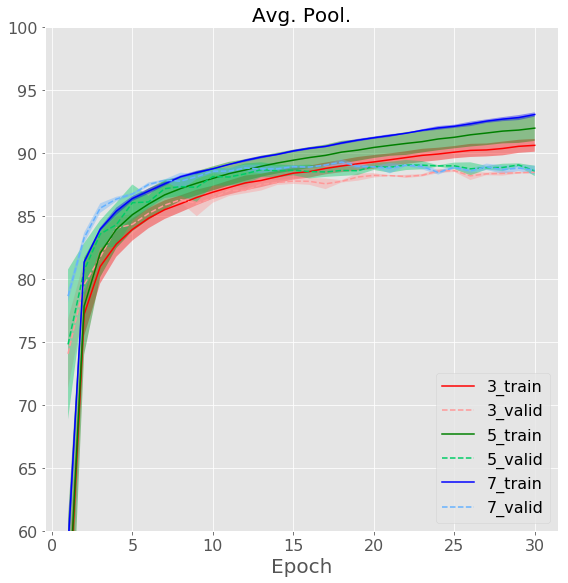

In [12]:
# training accuracy plot
plt.figure(figsize=(8,8))
colors = ['r', 'g', 'b', 'm']
colors2 = ['#FF9999', '#00CC66', '#66B2FF', '#CC99FF']
downsample = 'avg_pooling' 
for model_name, c, c2 in zip(model_names,  colors, colors2):
    statistics = stats_means[downsample + model_name]
    train_acc = statistics['train_acc']
    valid_acc = statistics['val_acc']
    train_error = stats_stds[downsample + model_name]['train_acc']
    valid_error = stats_stds[downsample + model_name]['val_acc']
    plt.plot(np.arange(1, len(train_acc)+1), np.array(train_acc, dtype='float'), label=model_name+'_train', c=c)
    plt.fill_between(np.arange(1, len(train_acc)+1), train_acc - train_error, train_acc + train_error, alpha=0.4, facecolor=c)
    plt.plot(np.arange(1, len(valid_acc)+1), np.array(valid_acc, dtype='float'), label=model_name+'_valid', c=c2, linestyle='--')
    plt.fill_between(np.arange(1, len(valid_acc)+1), valid_acc - valid_error, valid_acc + valid_error, alpha=0.4 ,facecolor=c2)
    
plt.legend(loc=4, fontsize=16)
plt.ylim((60, 100))
# plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()
plt.title('Avg. Pool.', fontsize=20)
plt.savefig('./plots/kernel_avg.pdf', dpi=400)
# 

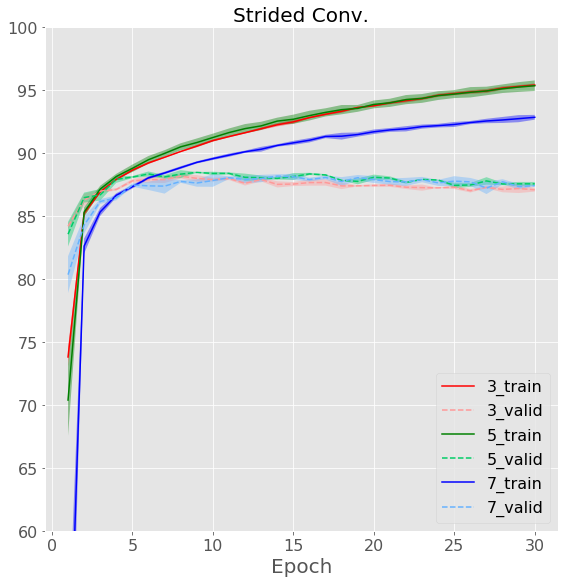

In [13]:
# training accuracy plot
plt.figure(figsize=(8,8))
colors = ['r', 'g', 'b', 'm']
colors2 = ['#FF9999', '#00CC66', '#66B2FF', '#CC99FF']
downsample = 'strided_convolution'
for model_name, c, c2 in zip(model_names,  colors, colors2):
    statistics = stats_means[downsample + model_name]
    train_acc = statistics['train_acc']
    valid_acc = statistics['val_acc']
    train_error = stats_stds[downsample + model_name]['train_acc']
    valid_error = stats_stds[downsample + model_name]['val_acc']
    plt.plot(np.arange(1, len(train_acc)+1), np.array(train_acc, dtype='float'), label=model_name+'_train', c=c)
    plt.fill_between(np.arange(1, len(train_acc)+1), train_acc - train_error, train_acc + train_error, alpha=0.4, facecolor=c)
    plt.plot(np.arange(1, len(valid_acc)+1), np.array(valid_acc, dtype='float'), label=model_name+'_valid', c=c2, linestyle='--')
    plt.fill_between(np.arange(1, len(valid_acc)+1), valid_acc - valid_error, valid_acc + valid_error, alpha=0.4 ,facecolor=c2)
    
plt.legend(loc=4, fontsize=16)
plt.ylim((60, 100))
# plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()
plt.title('Strided Conv.', fontsize=20)
plt.savefig('./plots/kernel_sc.pdf', dpi=400)
# 

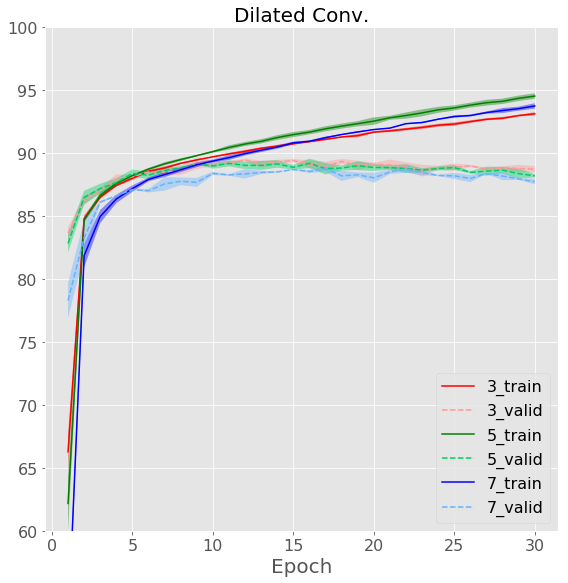

In [14]:
# training accuracy plot
plt.figure(figsize=(8,8))
colors = ['r', 'g', 'b', 'm']
colors2 = ['#FF9999', '#00CC66', '#66B2FF', '#CC99FF']
downsample = 'dilated_convolution'
for model_name, c, c2 in zip(model_names,  colors, colors2):
    statistics = stats_means[downsample + model_name]
    train_acc = statistics['train_acc']
    valid_acc = statistics['val_acc']
    train_error = stats_stds[downsample + model_name]['train_acc']
    valid_error = stats_stds[downsample + model_name]['val_acc']
    plt.plot(np.arange(1, len(train_acc)+1), np.array(train_acc, dtype='float'), label=model_name+'_train', c=c)
    plt.fill_between(np.arange(1, len(train_acc)+1), train_acc - train_error, train_acc + train_error, alpha=0.4, facecolor=c)
    plt.plot(np.arange(1, len(valid_acc)+1), np.array(valid_acc, dtype='float'), label=model_name+'_valid', c=c2, linestyle='--')
    plt.fill_between(np.arange(1, len(valid_acc)+1), valid_acc - valid_error, valid_acc + valid_error, alpha=0.4 ,facecolor=c2)
    
plt.legend(loc=4, fontsize=16)
plt.ylim((60, 100))
# plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()
plt.title('Dilated Conv.', fontsize=20)
plt.savefig('./plots/kernel_dc.pdf', dpi=400)
# 

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params =[]
for downsample in downsamples:
    for model_name in model_names:
        conv_model = ConvolutionalNetwork(
            input_shape=(batch_size, image_num_channels, image_height, image_width),
            dim_reduction_type=downsample,
            num_output_classes=47, num_filters=64, num_layers=4, kernel_size=int(model_name), use_bias=True)

        model_save_dir = './outputs/run1/kernel/' + downsample + '/' + model_name + '/saved_models/'
        path = os.path.join(model_save_dir, "{}_{}".format("train_model", 29))

        device = torch.device('cpu')
        state = torch.load(path, map_location=device)
        new_state = rename_dict_key(state['network'])
        conv_model.load_state_dict(state_dict=new_state)
        conv_model.eval()
        models[model_name] = conv_model
        num = count_parameters(conv_model)
        num_params.append(num)

Building basic block of ConvolutionalNetwork using input shape (128, 1, 28, 28)
torch.Size([128, 64, 28, 28])
torch.Size([128, 64, 15, 15])
torch.Size([128, 64, 15, 15])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 5, 5])
torch.Size([128, 64, 5, 5])
torch.Size([128, 64, 3, 3])
shape before final linear layer torch.Size([128, 64, 2, 2])
Block is built, output volume is torch.Size([128, 47])
Building basic block of ConvolutionalNetwork using input shape (128, 1, 28, 28)
torch.Size([128, 64, 28, 28])
torch.Size([128, 64, 15, 15])
torch.Size([128, 64, 15, 15])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 5, 5])
torch.Size([128, 64, 5, 5])
torch.Size([128, 64, 3, 3])
shape before final linear layer torch.Size([128, 64, 2, 2])
Block is built, output volume is torch.Size([128, 47])
Building basic block of ConvolutionalNetwork using input shape (128, 1, 28, 28)
torch.Size([128, 64, 28, 28])
torch.Size([128, 64, 15, 15])
torch.Size

In [9]:
num_params

[123503,
 321135,
 617583,
 123503,
 321135,
 617583,
 271215,
 730991,
 1420655,
 271215,
 730991,
 1420655]

In [24]:
best_train_accs

['0.9129521446862996',
 '0.9123019366197183',
 '0.9161231594110115',
 '0.9097211107554417',
 '0.8967369558258643']

In [25]:
best_valid_accs

[0.8923399390243902,
 0.8892276422764228,
 0.8873856707317073,
 0.8828125,
 0.8736026422764228]

In [60]:
import math
# convnet =   [[7, 1, 3],[2 ,2, 1], [7, 1, 3], [2 ,2, 1], [7, 1, 3],[2 ,2, 1], [7, 1, 3], [2 ,2, 1],[5, 1, 1], [2 ,2, 1]]
# layer_names = ['conv1','pool1','conv2','pool2', 'conv3', 'pool3', 'conv4', 'pool4', 'conv5', 'pool5']

# convnet =   [[7, 1, 3],[7 ,2, 3], [7, 1, 3],[7 ,2, 3], [7, 1, 3],[7 ,2, 3], [7, 1, 3],[7 ,2, 3], [7, 1, 3],[7 ,2, 3],]
# layer_names = ['conv1','conv2','conv3', 'conv4', 'conv5', 'conv6', 'conv7', 'conv8', 'conv9', 'conv10']

convnet =   [[7, 1, 3],[13 ,1, 6], [7, 1, 3],[19 ,1, 9], [7, 1, 3],[25 ,1, 12], [7, 1, 3],[31 ,1, 15], [3, 1, 1], [13 ,1, 6],]
layer_names = ['conv1','conv2','conv3', 'conv4', 'conv5', 'conv6', 'conv7', 'conv8', 'conv9', 'conv10']

imsize = 28

def outFromIn(conv, layerIn):
  n_in = layerIn[0]
  j_in = layerIn[1]
  r_in = layerIn[2]
  start_in = layerIn[3]
  k = conv[0]
  s = conv[1]
  p = conv[2]
  
  n_out = math.floor((n_in - k + 2*p)/s) + 1
  actualP = (n_out-1)*s - n_in + k 
  pR = math.ceil(actualP/2)
  pL = math.floor(actualP/2)
  
  j_out = j_in * s
  r_out = r_in + (k - 1)*j_in
  start_out = start_in + ((k-1)/2 - pL)*j_in
  return n_out, j_out, r_out, start_out
  
def printLayer(layer, layer_name):
  print(layer_name + ":")
  print("\t n features: %s \n \t jump: %s \n \t receptive size: %s \t start: %s " % (layer[0], layer[1], layer[2], layer[3]))

In [61]:
layerInfos = []
# first layer is the data layer (image) with n_0 = image size; j_0 = 1; r_0 = 1; and start_0 = 0.5
print ("-------Net summary------")
currentLayer = [imsize, 1, 1, 0.5]
printLayer(currentLayer, "input image")
for i in range(len(convnet)):
    currentLayer = outFromIn(convnet[i], currentLayer)
    layerInfos.append(currentLayer)
    printLayer(currentLayer, layer_names[i])
print ("------------------------")
layer_name = raw_input ("Layer name where the feature in: ")
layer_idx = layer_names.index(layer_name)
idx_x = int(raw_input ("index of the feature in x dimension (from 0)"))
idx_y = int(raw_input ("index of the feature in y dimension (from 0)"))

n = layerInfos[layer_idx][0]
j = layerInfos[layer_idx][1]
r = layerInfos[layer_idx][2]
start = layerInfos[layer_idx][3]
assert(idx_x < n)
assert(idx_y < n)

print ("receptive field: (%s, %s)" % (r, r))
print ("center: (%s, %s)" % (start+idx_x*j, start+idx_y*j))

-------Net summary------
input image:
	 n features: 28 
 	 jump: 1 
 	 receptive size: 1 	 start: 0.5 
conv1:
	 n features: 28 
 	 jump: 1 
 	 receptive size: 7 	 start: 0.5 
conv2:
	 n features: 28 
 	 jump: 1 
 	 receptive size: 19 	 start: 0.5 
conv3:
	 n features: 28 
 	 jump: 1 
 	 receptive size: 25 	 start: 0.5 
conv4:
	 n features: 28 
 	 jump: 1 
 	 receptive size: 43 	 start: 0.5 
conv5:
	 n features: 28 
 	 jump: 1 
 	 receptive size: 49 	 start: 0.5 
conv6:
	 n features: 28 
 	 jump: 1 
 	 receptive size: 73 	 start: 0.5 
conv7:
	 n features: 28 
 	 jump: 1 
 	 receptive size: 79 	 start: 0.5 
conv8:
	 n features: 28 
 	 jump: 1 
 	 receptive size: 109 	 start: 0.5 
conv9:
	 n features: 28 
 	 jump: 1 
 	 receptive size: 111 	 start: 0.5 
conv10:
	 n features: 28 
 	 jump: 1 
 	 receptive size: 123 	 start: 0.5 
------------------------


NameError: name 'raw_input' is not defined